In [1]:
import jax.numpy as jnp
import jax.scipy as jsp
import jax

from nnp_functions.pf_vehicle import PFVehicle
from nnp_functions.particle_filter import ParticleFilter
from nnp_functions.neural_networks import FeedForwardNetwork



In [2]:
TAU = 1 / (256 * 8 * 60)
KAPPA = 12
X_BAR = jnp.log(0.16)
SIGMA_SIGMA = 6.4
RHO = -0.5

## Stoch Vol Experiments State Space Functions

In [3]:
def f_from_noise(last_val, noise):
    """
    Evolve the hidden state using the stochastic volatility model.
    
    Args:
        last_val: Previous hidden state value
        noise: Random noise for the evolution
        
    Returns:
        next_val: Next hidden state value
    """
    means = last_val + TAU * KAPPA * (X_BAR - last_val)
    std = jnp.sqrt(TAU) * SIGMA_SIGMA
    next_val = noise * std + means
    return next_val

def f_sample_fn(subkey, particles, Y_array, idt):
    return f_from_noise(particles, jax.random.normal(subkey, len(particles)))
    

def g_from_total_noise(prev_particle, all_particles, total_noise):
    """
    Generate observations from hidden states using the observation model.
    
    Args:
        all_particles: Hidden state particles
        total_noise: Random noise for observations
        
    Returns:
        observations: Generated observations
    """
    y_means = -0.5 * TAU * jnp.exp(2 * all_particles)
    y_stds = jnp.sqrt(TAU) * jnp.exp(all_particles)
    
    return total_noise * y_stds + y_means

In [4]:
def f_likelihood_single(
        particle: float, prev_particle: float, Y_array, idt
        ) -> float: 
    """
    Calculate the transition probability density for the stochastic volatility model.
    
    Parameters:
    -----------
    particle : float
        Current particle state (log volatility)
    prev_particle : float
        Previous particle state (log volatility)
        
    Returns:
    --------
    float
        Log probability density of the transition from prev_particle to particle
    """
    
    # Calculate transition parameters
    f_means = prev_particle + TAU * KAPPA * (X_BAR - prev_particle)  # Mean reversion
    f_std = jnp.sqrt(TAU) * SIGMA_SIGMA  # Transition noise scale
    
    # Calculate log probability density
    f_x_given_x_prev = jsp.stats.norm.logpdf(particle, f_means, f_std)
    
    return f_x_given_x_prev 

def g_likelihood_single(particle, prev_particle, Y_array, idt
        ) -> float: 
    """
    Calculate the likelihood of a value 'val' given a hidden log standard deviation 'hidden_log_std' under the stochastic volatility model.
    
    Parameters:
    val (float): The value for which likelihood is calculated
    hidden_log_std (float): The hidden log standard deviation
    prev_hidden_log_std (float): The previous hidden log standard deviation, which is not used in the calculation.
    
    Returns:
    float: The likelihood of the value 'val' given the hidden log standard deviation
    """
    
    std = jnp.sqrt(TAU) * jnp.exp(prev_particle)  # full variance
    mean = -0.5 * std**2  # expected mean
    
    return jsp.stats.norm.logpdf(Y_array.at[idt].get(), mean, std)

g_likelihood_weight_fn = jax.vmap(g_likelihood_single, in_axes=(0, 0, None, None))


# Experiments

Show:
- Higher ess suggests better filtering performance. Shown with what we have previously
    - However it doesnt result in better forecasting performance. 
    - Experiment into VolMAE and how it relates to ESS. 

- We expect not to get better ESS performance here. 
    - Run ar1 code and include the plot of ess diff. 

Methodology:
- Your going to want a scatter plot of average ESS against filtering performance metrics. Thus will want some form of loop of what you have for the ar1 examples. 

- Will need to implement VolMAE
    - Simple add to PF.




In [5]:
# Planning varied pf loop. 
# Q1: do we want to compare affects for boostrap and trained? 
# Remeber that throughout vmap will not be very easy. <- stacking diagnostics also not that hard


TRAIN_KEY = jax.random.key(112)
DATA_KEY = jax.random.key(72)
EVAL_KEY = jax.random.key(80)
INIT_PARTICLE_KEY = jax.random.key(16)

In [6]:
stoch_vol_vehicle = PFVehicle(f_from_noise, g_from_total_noise, f_likelihood_single, g_likelihood_single)

stoch_bootstrap_pf = ParticleFilter(f_sample_fn, g_likelihood_single)


  0%|          | 0/1000 [00:00<?, ?it/s]

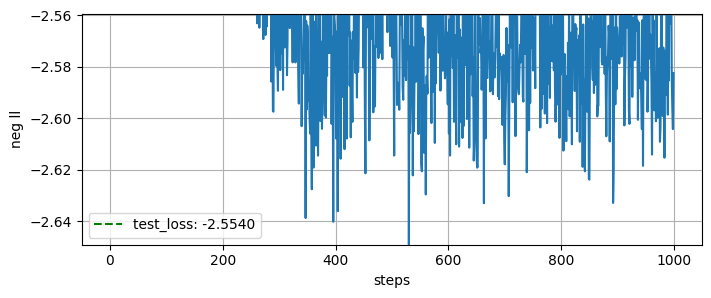

In [7]:
initial_model = FeedForwardNetwork(1, 64, jax.random.key(72))
stoch_vol_vehicle.train_model(
    TRAIN_KEY, 
    initial_model,
    1000, 
    steps = 1000, 
    X_bar = X_BAR
)

In [8]:
PARTICLE_VALS = [50, 500, 1000]
SIMULATE_AT = [0.9]
N_RUNS = 1
N_TIMESTEPS = 1000

In [9]:
All_X, All_Y = stoch_vol_vehicle.generate_data(
    DATA_KEY,
    N_RUNS,
    N_TIMESTEPS,
    starting_point = X_BAR
)

In [10]:
def stack_dicts(dict_list):
    return {
        key: jnp.stack([d[key] for d in dict_list], axis=0)
        for key in dict_list[0]
    }

In [11]:
total_n_merged_diag = {}
total_n_forecast_metrics = {}
total_b_merged_diag = {}
total_b_forecast_metrics = {}

eval_key = EVAL_KEY

print("Starting particle filter experiments across different particle counts...")
for particle_N in PARTICLE_VALS:
    print(f"\n{'='*60}")
    print(f"Running experiments for particle count: {particle_N}")

    initial_particles = jax.random.normal(INIT_PARTICLE_KEY, (particle_N,)) * 0.1 + X_BAR
    initial_log_weights = jnp.zeros(particle_N) - jnp.log(particle_N)

    print("  - Initializing neural network particle filter...")
    nn_particle_filter = stoch_vol_vehicle.build_NN_particle_filter(N_PARTICLES = particle_N)
    print("  - Initializing bootstrap particle filter...")
    stoch_bootstrap_pf = ParticleFilter(f_sample_fn, g_likelihood_single, N_PARTICLES = particle_N)

    nn_merged_diag_list = []
    bootstrap_merged_diag_list = []

    nn_total_forecast_metrics = []
    bootstrap_total_forecast_metrics = []
    
    for run_idx in range(N_RUNS):

        key, eval_key = jax.random.split(eval_key)

        print(f"    > Run {run_idx+1}/{N_RUNS} for particle_N={particle_N} (NN PF)...")
        Y_array, X_array = All_Y[run_idx], All_X[run_idx]

        nn_merge, _, nn_forecast_metrics = stoch_vol_vehicle.run_from_particle_filter(
            key, nn_particle_filter, Y_array, X_array, initial_particles,
            simulate_at = SIMULATE_AT,
            tau = TAU
        )
        print(f"      - Neural network PF diagnostics collected.")

        nn_merged_diag_list.append(nn_merge)
        nn_total_forecast_metrics.append(nn_forecast_metrics)

        print(f"    > Run {run_idx+1}/{N_RUNS} for particle_N={particle_N} (Bootstrap PF)...")
        bootstrap_merge, _, bootstrap_forecast_metrics = stoch_vol_vehicle.run_from_particle_filter(
            key, stoch_bootstrap_pf, Y_array, X_array, initial_particles,
            simulate_at = SIMULATE_AT,
            tau = TAU
        )
        print(f"      - Bootstrap PF diagnostics collected.")

        bootstrap_merged_diag_list.append(bootstrap_merge)
        bootstrap_total_forecast_metrics.append(bootstrap_forecast_metrics)

    print(f"  - Aggregating diagnostics for particle_N={particle_N}...")
    total_n_merged_diag[particle_N] = stack_dicts(nn_merged_diag_list)
    total_b_merged_diag[particle_N] = stack_dicts(bootstrap_merged_diag_list)
    total_n_forecast_metrics[particle_N] = (nn_total_forecast_metrics)
    total_b_forecast_metrics[particle_N] = (bootstrap_total_forecast_metrics)
    print(f"  - Completed aggregation for particle_N={particle_N}.")

print("\nAll particle filter experiments completed successfully.")


Starting particle filter experiments across different particle counts...

Running experiments for particle count: 50
  - Initializing neural network particle filter...
  - Initializing bootstrap particle filter...
    > Run 1/1 for particle_N=50 (NN PF)...


Processing segments:   0%|          | 0/1 [00:00<?, ?segment/s]

      - Neural network PF diagnostics collected.
    > Run 1/1 for particle_N=50 (Bootstrap PF)...


Processing segments:   0%|          | 0/1 [00:00<?, ?segment/s]

      - Bootstrap PF diagnostics collected.
  - Aggregating diagnostics for particle_N=50...
  - Completed aggregation for particle_N=50.

Running experiments for particle count: 500
  - Initializing neural network particle filter...
  - Initializing bootstrap particle filter...
    > Run 1/1 for particle_N=500 (NN PF)...


Processing segments:   0%|          | 0/1 [00:00<?, ?segment/s]

      - Neural network PF diagnostics collected.
    > Run 1/1 for particle_N=500 (Bootstrap PF)...


Processing segments:   0%|          | 0/1 [00:00<?, ?segment/s]

      - Bootstrap PF diagnostics collected.
  - Aggregating diagnostics for particle_N=500...
  - Completed aggregation for particle_N=500.

Running experiments for particle count: 1000
  - Initializing neural network particle filter...
  - Initializing bootstrap particle filter...
    > Run 1/1 for particle_N=1000 (NN PF)...


Processing segments:   0%|          | 0/1 [00:00<?, ?segment/s]

      - Neural network PF diagnostics collected.
    > Run 1/1 for particle_N=1000 (Bootstrap PF)...


Processing segments:   0%|          | 0/1 [00:00<?, ?segment/s]

      - Bootstrap PF diagnostics collected.
  - Aggregating diagnostics for particle_N=1000...
  - Completed aggregation for particle_N=1000.

All particle filter experiments completed successfully.


## Forecasting Evaluation 

First we need to unders

In [14]:
from pprint import pprint 

pprint(total_n_forecast_metrics)

{50: [{899: {'kde_mse': Array(0.00248797, dtype=float32),
             'likelihood': Array([2.3813245], dtype=float32),
             'total_coverage': Array(0., dtype=float32),
             'total_mse': Array(0.10905708, dtype=float32)}}],
 500: [{899: {'kde_mse': Array(0.00154517, dtype=float32),
              'likelihood': Array([2.4521823], dtype=float32),
              'total_coverage': Array(0., dtype=float32),
              'total_mse': Array(0.08823783, dtype=float32)}}],
 1000: [{899: {'kde_mse': Array(0.00171108, dtype=float32),
               'likelihood': Array([2.4810028], dtype=float32),
               'total_coverage': Array(0., dtype=float32),
               'total_mse': Array(0.09041778, dtype=float32)}}]}


In [ ]:
f